In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
%cd drive/My Drive

/content/drive/My Drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
from tensorflow.keras import backend as K
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [4]:
train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

train_img_norm = train_img / 255.0
test_img_norm = test_img / 255.0

features = train_img_norm
labels = train_digit.to_numpy()

X_test = test_img_norm

from sklearn.model_selection import train_test_split

validation_split = 0.2

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = validation_split, random_state = 100)

In [5]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [37]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))
    
    # CNN
    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.BatchNormalization()(img_input)
    conv_1 = layers.Activation('mish')(conv_1)
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',)(conv_1) 
    
    conv_2_1 = layers.BatchNormalization()(conv_1)
    conv_2_1 = layers.Activation('mish')(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    conv_2_1 = layers.Dropout(rate = 0.3)(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('mish')(add_2_1)
    
    conv_2_2 = layers.BatchNormalization()(out_2_1)
    conv_2_2 = layers.Activation('mish')(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    conv_2_2 = layers.Dropout(rate = 0.3)(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('mish')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)

    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('mish')(add_3_1)
    
    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.BatchNormalization()(conv_4_0)
    conv_4_1 = layers.Activation('mish')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('mish')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)

    conv_5_0 = layers.Conv2D(512, kernel_size = 1, strides = 1)(pool_4)
    
    conv_5_1 = layers.BatchNormalization()(conv_5_0)
    conv_5_1 = layers.Activation('mish')(conv_5_1)
    conv_5_1 = layers.Conv2D(512, kernel_size = 3, padding = 'same')(conv_5_1)
    conv_5_1 = layers.Conv2D(512, kernel_size = 3, padding = 'same',activation = 'mish')(conv_5_1)
    
    # ShortCut connection
    add_5_1 = layers.add([conv_5_0, conv_5_1])
    out_5_1 = layers.Activation('mish')(add_5_1)
    
    # FC layers
    img_features = layers.Flatten()(out_5_1)
    img_features = layers.BatchNormalization()(img_features)
    img_features = layers.Dense(1024, activation = 'mish')(img_features)
    img_features = layers.Dropout(rate = 0.3)(img_features)
    img_features = layers.Dense(512, activation = 'mish')(img_features)
    img_features = layers.Dropout(rate = 0.3)(img_features)
    img_features = layers.Dense(256, activation = 'mish')(img_features)
    # Output layer
    digit_pred = layers.Dense(10, activation = 'softmax')(img_features)
    
    model = tf.keras.Model(inputs = img_input, outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model


def train_model_v1(model, X_train, y_train, epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 3, min_lr = 3e-5)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_split = validation_split, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train,  epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 3, min_lr = 3e-5)
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_split = validation_split, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [38]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0003)
    model_list.append(model)

In [33]:
model_list[0].summary()

Model: "functional_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_380 (BatchN (None, 28, 28, 1)    4           input_51[0][0]                   
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 28, 28, 1)    0           batch_normalization_380[0][0]    
__________________________________________________________________________________________________
conv2d_740 (Conv2D)             (None, 28, 28, 128)  1280        activation_610[0][0]             
_____________________________________________________________________________________

***************Trainig_my_model_0*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.2378 - accuracy: 0.2827 - val_loss: 3.8288 - val_accuracy: 0.0976
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7604 - accuracy: 0.3923 - val_loss: 6.6522 - val_accuracy: 0.0585
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.4637 - accuracy: 0.5035 - val_loss: 4.4964 - val_accuracy: 0.1122
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.1748 - accuracy: 0.6023 - val_loss: 3.3513 - val_accuracy: 0.1317
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9384 - accuracy: 0.6799 - val_loss: 2.7352 - val_accuracy: 0.2780
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.8288 - accuracy: 0.7184 - val_loss: 2.0589 - val_accuracy: 0.5220
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6422 - 

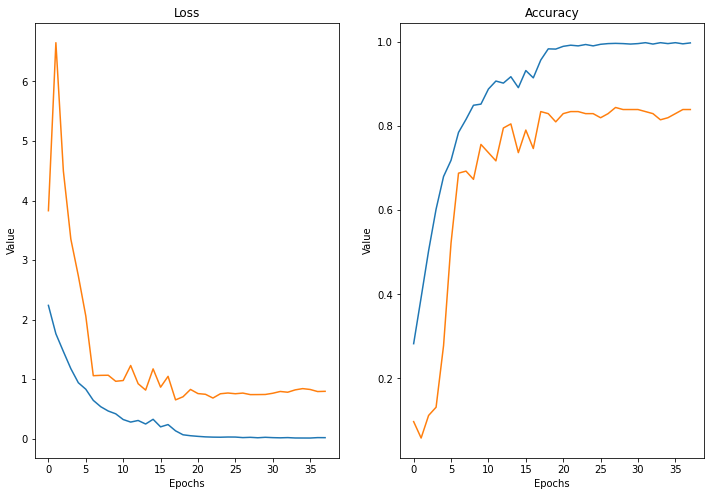

***************Trainig_my_model_1*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.2537 - accuracy: 0.2778 - val_loss: 4.0630 - val_accuracy: 0.0585
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7736 - accuracy: 0.3831 - val_loss: 7.1792 - val_accuracy: 0.0585
Epoch 3/200
116/116 [==============================] - 2s 13ms/step - loss: 1.4759 - accuracy: 0.4883 - val_loss: 8.6241 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.2234 - accuracy: 0.6007 - val_loss: 4.8637 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 2s 13ms/step - loss: 0.9204 - accuracy: 0.6842 - val_loss: 2.1458 - val_accuracy: 0.4488
Epoch 6/200
116/116 [==============================] - 2s 13ms/step - loss: 0.7898 - accuracy: 0.7390 - val_loss: 1.2661 - val_accuracy: 0.5805
Epoch 7/200
116/116 [==============================] - 2s 13ms/step - loss: 0.5893 - 

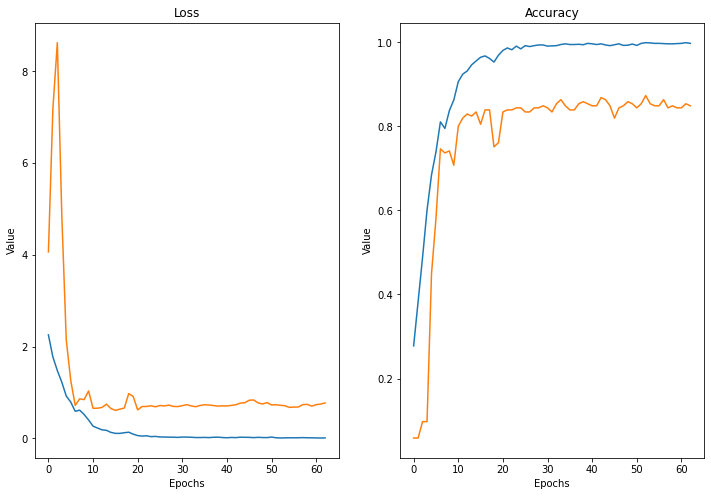

***************Trainig_my_model_2*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.1030 - accuracy: 0.3125 - val_loss: 3.1036 - val_accuracy: 0.0585
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7601 - accuracy: 0.4015 - val_loss: 5.2833 - val_accuracy: 0.0341
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5044 - accuracy: 0.4813 - val_loss: 6.5038 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.2253 - accuracy: 0.5800 - val_loss: 5.0431 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9510 - accuracy: 0.6869 - val_loss: 2.2974 - val_accuracy: 0.4098
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.8220 - accuracy: 0.7254 - val_loss: 1.2038 - val_accuracy: 0.6098
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6738 - 

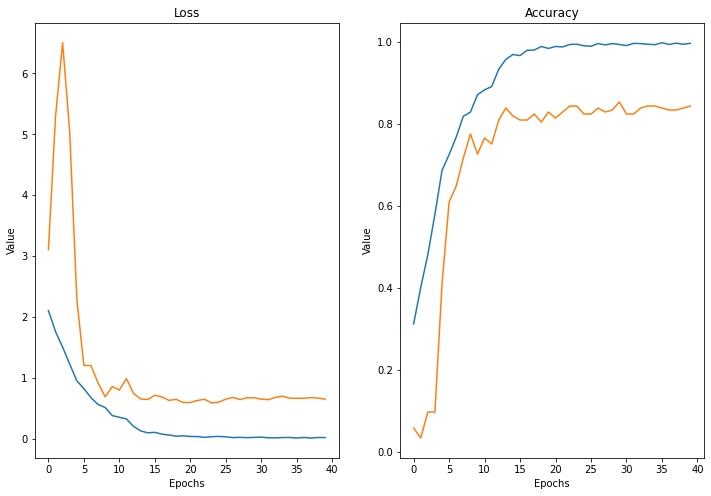

***************Trainig_my_model_3*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.2715 - accuracy: 0.2626 - val_loss: 3.6991 - val_accuracy: 0.0585
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7997 - accuracy: 0.3700 - val_loss: 5.2181 - val_accuracy: 0.0585
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5520 - accuracy: 0.4704 - val_loss: 5.8888 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.3122 - accuracy: 0.5610 - val_loss: 4.2503 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9836 - accuracy: 0.6701 - val_loss: 2.9593 - val_accuracy: 0.3024
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.7905 - accuracy: 0.7352 - val_loss: 1.6038 - val_accuracy: 0.5366
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6383 - 

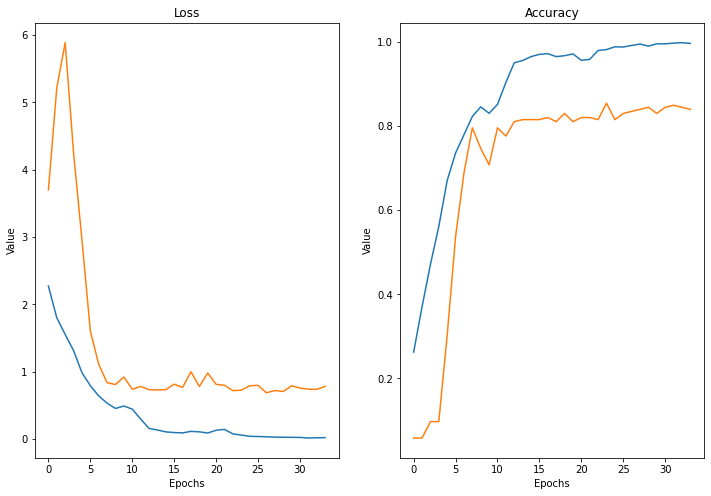

***************Trainig_my_model_4*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.2404 - accuracy: 0.2626 - val_loss: 2.9557 - val_accuracy: 0.0585
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7654 - accuracy: 0.3907 - val_loss: 4.5788 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5191 - accuracy: 0.4764 - val_loss: 4.5128 - val_accuracy: 0.1415
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.2258 - accuracy: 0.5784 - val_loss: 5.6114 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9765 - accuracy: 0.6663 - val_loss: 3.2592 - val_accuracy: 0.2585
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.8055 - accuracy: 0.7379 - val_loss: 1.2430 - val_accuracy: 0.6098
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6771 - 

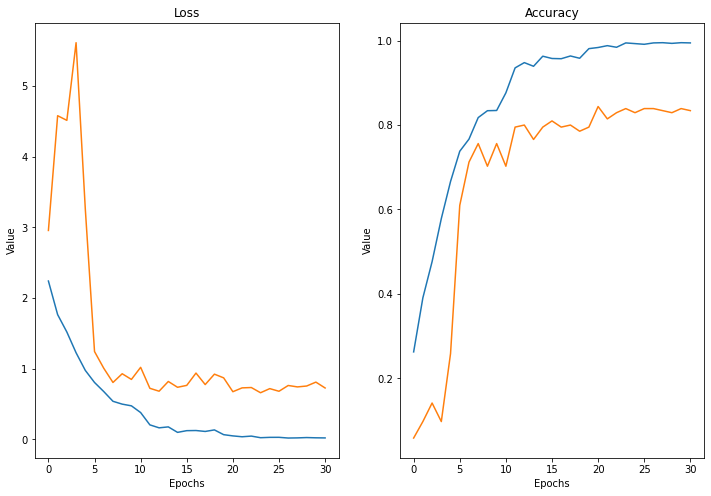

***************Trainig_my_model_5*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.1923 - accuracy: 0.3033 - val_loss: 4.0679 - val_accuracy: 0.0585
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7608 - accuracy: 0.4031 - val_loss: 5.8247 - val_accuracy: 0.0585
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.4934 - accuracy: 0.4927 - val_loss: 7.3484 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.2522 - accuracy: 0.5762 - val_loss: 5.0963 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9643 - accuracy: 0.6712 - val_loss: 4.0534 - val_accuracy: 0.1366
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.7631 - accuracy: 0.7482 - val_loss: 1.0871 - val_accuracy: 0.6341
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6964 - 

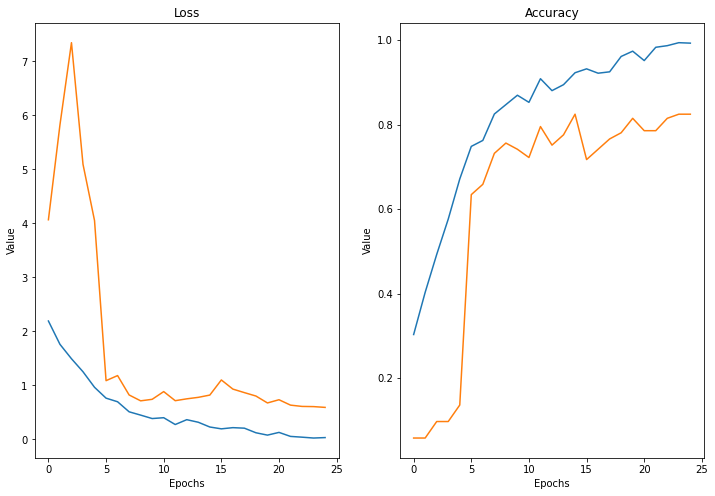

***************Trainig_my_model_6*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.2537 - accuracy: 0.2767 - val_loss: 4.0867 - val_accuracy: 0.0585
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7683 - accuracy: 0.3977 - val_loss: 5.1587 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5538 - accuracy: 0.4731 - val_loss: 5.5150 - val_accuracy: 0.1073
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.2126 - accuracy: 0.5974 - val_loss: 7.8683 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9935 - accuracy: 0.6706 - val_loss: 4.0085 - val_accuracy: 0.1512
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.7986 - accuracy: 0.7363 - val_loss: 0.7912 - val_accuracy: 0.7122
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6374 - 

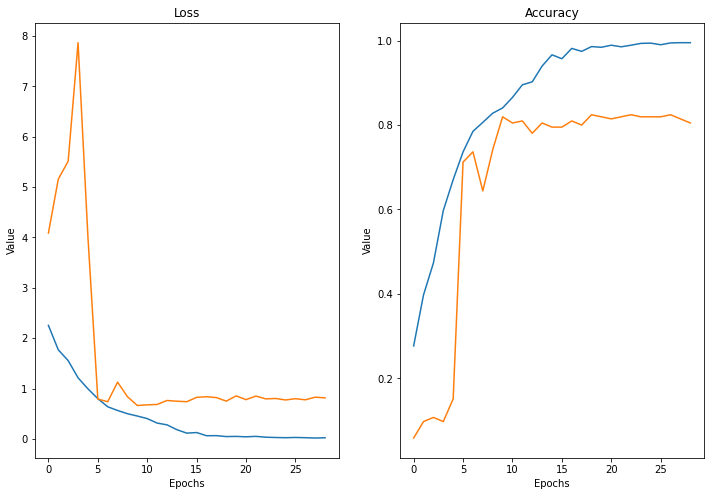

***************Trainig_my_model_7*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.3339 - accuracy: 0.2507 - val_loss: 3.1396 - val_accuracy: 0.0634
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.8433 - accuracy: 0.3793 - val_loss: 4.3969 - val_accuracy: 0.0585
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5706 - accuracy: 0.4493 - val_loss: 5.1266 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.3565 - accuracy: 0.5350 - val_loss: 4.0438 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 1.1069 - accuracy: 0.6202 - val_loss: 3.1257 - val_accuracy: 0.2000
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9072 - accuracy: 0.6983 - val_loss: 1.0406 - val_accuracy: 0.6195
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6826 - 

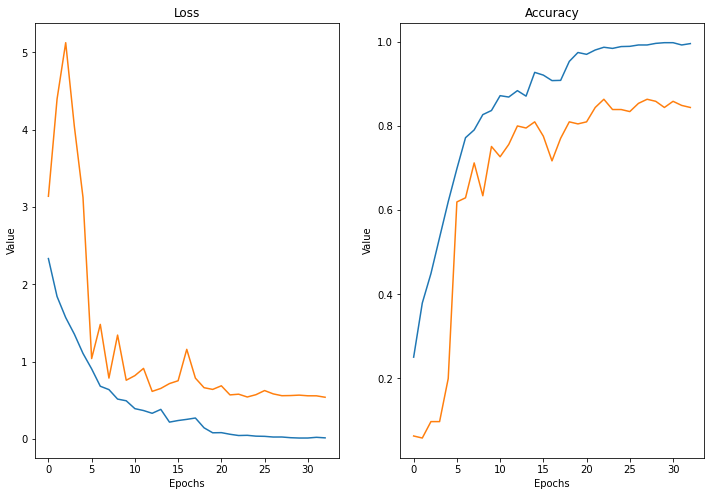

***************Trainig_my_model_8*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.1273 - accuracy: 0.2968 - val_loss: 3.1879 - val_accuracy: 0.1171
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7579 - accuracy: 0.4037 - val_loss: 6.6621 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 12ms/step - loss: 1.5461 - accuracy: 0.4699 - val_loss: 5.4439 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.2945 - accuracy: 0.5610 - val_loss: 3.5521 - val_accuracy: 0.1512
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 0.9585 - accuracy: 0.6750 - val_loss: 1.8592 - val_accuracy: 0.4634
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.7698 - accuracy: 0.7461 - val_loss: 1.5357 - val_accuracy: 0.5610
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6557 - 

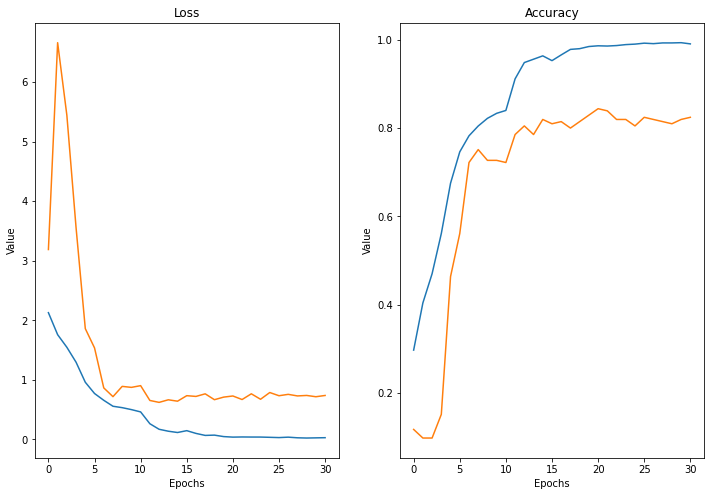

***************Trainig_my_model_9*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.2404 - accuracy: 0.2827 - val_loss: 5.9228 - val_accuracy: 0.0976
Epoch 2/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7968 - accuracy: 0.3939 - val_loss: 8.4483 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 12ms/step - loss: 1.5194 - accuracy: 0.4965 - val_loss: 6.8283 - val_accuracy: 0.0976
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.2328 - accuracy: 0.5844 - val_loss: 6.9598 - val_accuracy: 0.0976
Epoch 5/200
116/116 [==============================] - 1s 12ms/step - loss: 0.8598 - accuracy: 0.7119 - val_loss: 7.4036 - val_accuracy: 0.0976
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 0.6772 - accuracy: 0.7759 - val_loss: 1.8164 - val_accuracy: 0.5024
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 0.5924 - 

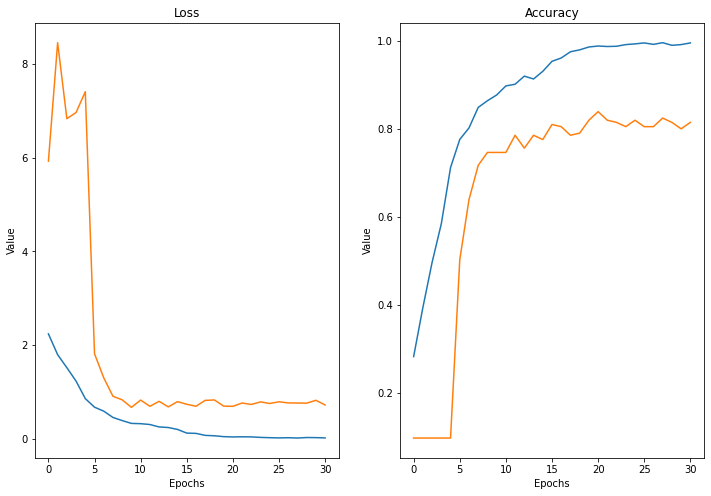

In [39]:
epochs = 200
batch_size = 16
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], features, labels, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [40]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(X_val, y_val)
    result_list.append(result)

************************Evaluating_my_model_0************************
13/13 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.9829
************************Evaluating_my_model_1************************
13/13 [==============================] - 0s 6ms/step - loss: 0.0640 - accuracy: 0.9854
************************Evaluating_my_model_2************************
13/13 [==============================] - 0s 6ms/step - loss: 0.0593 - accuracy: 0.9854
************************Evaluating_my_model_3************************
13/13 [==============================] - 0s 6ms/step - loss: 0.0655 - accuracy: 0.9829
************************Evaluating_my_model_4************************
13/13 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.9805
************************Evaluating_my_model_5************************
13/13 [==============================] - 0s 6ms/step - loss: 0.2155 - accuracy: 0.9366
************************Evaluating_my_model_6*************

In [41]:
pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_model_{}************************".format(i))
    pred = model_list[i].predict(X_test)
    pred_list.append(pred)

************************Predicting_my_model_0************************
************************Predicting_my_model_1************************
************************Predicting_my_model_2************************
************************Predicting_my_model_3************************
************************Predicting_my_model_4************************
************************Predicting_my_model_5************************
************************Predicting_my_model_6************************
************************Predicting_my_model_7************************
************************Predicting_my_model_8************************
************************Predicting_my_model_9************************


In [42]:
pred_df = pd.DataFrame(test["id"])
final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    pred_df['pred{}'.format(i)] = np.argmax(pred_list[i], axis = 1)
    final_pred = final_pred + pred_list[i]

pred_df['final_pred'] = np.argmax(final_pred, axis = 1)

In [43]:
pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,9,8,9,9,9,9,9,9,9,9
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,1,1,1,1,1,8,1,1,3,1,1


In [44]:
submission = pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,1


여기까지....

# 추가한 것

- resnet 구조에 batch normalization 과 dropout을 추가
- activation function으로  mish 사용
- callback에 learning rate 조절하는 옵션넣음

- **그렇지만 성능이 떨어졌다...(0.91 -> 0.88)**

반도체 박막 두께에서 사용한 resnet모델을 사용해도 성능이 안 좋았음.
(그리고 layer개수를 비슷하게 했을 때 계산해야할 parameter가 약 1억개...현재는 5백만개 정도)

<br/>


## 생각해야 할 것

- 알파벳에서 숫자를 더 확실하게 분류할 방법
- 데이터 증강을 하면 성능이 오를 것인가...?

In [18]:
for i in range(len(model_list)):
  tf.keras.models.save_model(model_list[i],'ckpt1/model{}'.format(i))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ckpt1/model0/assets
INFO:tensorflow:Assets written to: ckpt1/model1/assets
INFO:tensorflow:Assets written to: ckpt1/model2/assets
INFO:tensorflow:Assets written to: ckpt1/model3/assets
INFO:tensorflow:Assets written to: ckpt1/model4/assets
INFO:tensorflow:Assets written to: ckpt1/model5/assets
INFO:tensorflow:Assets written to: ckpt1/model6/assets
INFO:tensorflow:Assets written to: ckpt1/model7/assets
INFO:tensorflow:Assets written to: ckpt1/model8/assets
INFO:tensorflow:Assets written to: ckpt1/model9/assets


In [20]:
re_model_list = []

for i in range(len(model_list)):
    print("************************Loading_my_model_{}************************".format(i))
    my_model = tf.keras.models.load_model('ckpt1/model{}'.format(i))
    my_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00005),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    print("************************Re-training_my_model_{}************************".format(i))
    my_model.fit(X_val, y_val, epochs = 10, batch_size = 1,validation_split=0.1)
    
    re_model_list.append(my_model)

************************Loading_my_model_0************************
************************Re-training_my_model_0************************
Epoch 1/10
369/369 [==============================] - 3s 7ms/step - loss: 3.0083 - accuracy: 0.0813 - val_loss: 0.1272 - val_accuracy: 0.9756
Epoch 2/10
369/369 [==============================] - 2s 6ms/step - loss: 2.6795 - accuracy: 0.0759 - val_loss: 0.3727 - val_accuracy: 0.9756
Epoch 3/10
369/369 [==============================] - 2s 6ms/step - loss: 2.4913 - accuracy: 0.1409 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
369/369 [==============================] - 2s 6ms/step - loss: 2.4797 - accuracy: 0.0894 - val_loss: 13.7209 - val_accuracy: 0.9756
Epoch 5/10
369/369 [==============================] - 2s 6ms/step - loss: 2.4277 - accuracy: 0.0705 - val_loss: 62.2502 - val_accuracy: 0.9756
Epoch 6/10
369/369 [==============================] - 2s 6ms/step - loss: 2.3557 - accuracy: 0.1274 - val_loss: 67.5156 - val_accuracy: 0.9756
Epo

KeyboardInterrupt: ignored

In [ ]:
re_pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_re_model_{}************************".format(i))
    pred = re_model_list[i].predict(X_test)
    re_pred_list.append(pred)

************************Predicting_my_re_model_0************************
************************Predicting_my_re_model_1************************
************************Predicting_my_re_model_2************************
************************Predicting_my_re_model_3************************
************************Predicting_my_re_model_4************************
************************Predicting_my_re_model_5************************
************************Predicting_my_re_model_6************************
************************Predicting_my_re_model_7************************
************************Predicting_my_re_model_8************************
************************Predicting_my_re_model_9************************


In [ ]:
re_pred_df = pd.DataFrame(test["id"])
re_final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    re_pred_df['pred{}'.format(i)] = np.argmax(re_pred_list[i], axis = 1)
    re_final_pred = re_final_pred + re_pred_list[i]

re_pred_df['final_pred'] = np.argmax(re_final_pred, axis = 1)

In [ ]:
re_pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,9,9,9,9,9,9,9,9,9,9
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,3,3,3,3,3,3,8,3,3,3,3


In [ ]:
submission = re_pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3
